# Машинное обучение, ФКН ВШЭ
## Практическое задание 4.

__Дата выдачи: 06.12.2016__

__Дедлайн: 18.12.2016 23:59 MSK__

Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: HW4_Username.ipynb, где Username — Ваша фамилия и инициалы на латинице (например, HW4_IvanovII.ipynb). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Кластеризация

![Digits](https://www.dropbox.com/s/nrjiahdbpswd63y/digits.png?dl=1)

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на заданное число кластеров, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть использован следующий подход: при фиксированной метрике качества для разного числа кластеров обучают алгоритм и выбирают то значение гиперпараметра, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации — не всегда тривиальная задача, поскольку следует учитывать ряд фактов:
 - объекты одного класса должны быть более похожими, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать истинные значения меток объектов, попавших в кластер (в случае, если истинные метки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure) 
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

In [108]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.metrics import homogeneity_score, adjusted_rand_score, silhouette_score, completeness_score, v_measure_score, homogeneity_completeness_v_measure
import matplotlib.image as img
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.io import imread
from sklearn.feature_extraction import image
from skimage.transform import downscale_local_mean
from skimage import color


Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения в случайном порядке.

In [109]:
digits = load_digits(return_X_y=True)
# print(digits[0][0])
perm = np.random.permutation(digits[0].shape[0])
X = digits[0][perm]
y = digits[1][perm]
# X[0]

**(1 балл)** Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), подобрав число кластеров для любой фиксированной метрики из указанных выше. Рассмотрите различные способы выбора начального приближения (параметр *init*). Оцените качество получившейся кластеризации, используя все описанные выше метрики. Визуализируйте изображения, соответствующие центроидам лучшей кластеризации.

In [110]:
# kmeans = KMeans(n_clusters=12, n_jobs=-1, init='k-means++').fit(X) 
kmeans_1 = KMeans(n_clusters=12, n_jobs=-1, init='random').fit(X) 
#настраиваться на homogeneity_score или completeness_score в отдельности странно 
# (для первой, например, чем больше классов тем выше значение (в разумных пределах, конечно), например k=220 даст ~0.99)
# поэтому будем настраиваться на их гаромническое среднее v-measure


In [116]:
def scores(X, y, kmeans):
    print("V-measure:", v_measure_score(y, kmeans.labels_))
    print("adjusted_rand:", adjusted_rand_score(y, kmeans.labels_))
    print("silhouette:", silhouette_score(X, kmeans.labels_, metric='euclidean'))
    return


scores(X, y, kmeans_1)


V-measure: 0.755487612281
adjusted_rand: 0.651463894321
silhouette: 0.186838766699


Согласно первым двум метрикам качество нормальное. В основном это означает, что каждый кластер имеет в своем большинстве представителей одного, и ,что большинство изображений одного класса (цифры) объеденены одним кластером.
adjusted_rand 0.65 означает неплохую единообразность последовательностей верных ответов и построенных предсказаний. Последний индекс замерял относительную разницу средних расстояний внутри классов и между классами(тоесть не учитывал устроенные) и означает плохую интерпретируемость построенной модели (его иделаьное значение 1). Тоесть, либо кластеры близко друг с другом находятся, либо они содержат очень разные объекты, либо и то и то вместе.

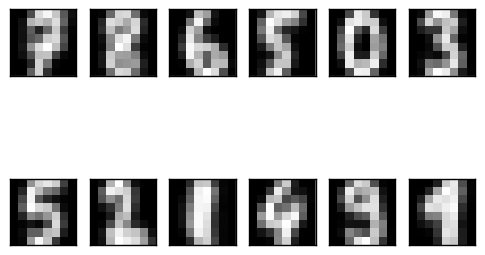

In [9]:
for i in range(kmeans_1.n_clusters):
    plt.subplot(2, 6, i + 1)
    plt.imshow(kmeans_1.cluster_centers_[i, :].reshape((8, 8)), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Не всегда бывает удобно работать с полной матрицей объект-признак — например, для визуализации подходят лишь выборки размерности не больше трёх. На лекциях был рассмотрен метод уменьшения размерности *PCA*. В документации sklearn есть [сравнение](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) различных способов понижения размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую визуализацию, где одинаковые цифры расположены близко друг к другу. Посмотрим, поможет ли это на практике.
 
**(1 балл)** Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2 и 10), проведите кластеризацию в новых признаковых пространствах и сравните результаты с предыдущими. Нашелся ли метод кластеризации, превосходящий другие по всем метрикам? Являются ли все три метрики согласованными? Можете ли вы объяснить, почему так произошло?

In [10]:
X = digits[0][perm]
pca_2 = PCA(n_components=2)
X = pca_2.fit_transform(X)
kmeans_2 = KMeans(n_clusters=12, n_jobs=-1, init='random').fit(X)
scores(X, y, kmeans_2)

V-measure: 0.524451651891
adjusted_rand: 0.379025818305
silhouette: 0.388119284058


In [11]:
X = digits[0][perm]
pca_10 = PCA(n_components=10)
X = pca_10.fit_transform(X)
kmeans_3 = KMeans(n_clusters=12, n_jobs=-1, init='random').fit(X)
scores(X, y, kmeans_3)

V-measure: 0.763411211098
adjusted_rand: 0.698744124283
silhouette: 0.263457127861


In [12]:
X = digits[0][perm]
tsne_2 = TSNE(n_components=2, method='exact')
X = tsne_2.fit_transform(X)
kmeans_4 = KMeans(n_clusters=12, n_jobs=-1, init='random').fit(X)
scores(X, y, kmeans_4)

V-measure: 0.882197971477
adjusted_rand: 0.849708760903
silhouette: 0.534047187692


In [14]:
%%time
X = digits[0][perm]
tsne_10 = TSNE(n_components=10, method='exact')
X = tsne_10.fit_transform(X)
kmeans_5 = KMeans(n_clusters=12, n_jobs=-1, init='random').fit(X)
scores(X, y, kmeans_5)

V-measure: 0.00855688447042
adjusted_rand: -0.00156769202843
silhouette: 0.0405819752733
CPU times: user 4min 13s, sys: 5min 43s, total: 9min 57s
Wall time: 3min 29s


Метод превосходящий другие по всем метрикам нашелся. Двухкомпонентный метод t-SNE показал наилучший результат среди всех по метрикам v-Score, adjusted_rand и silhouette_score. Не все три метрики являются согласованными. В частности первые две оперируют сравнением ответов, тоесть оценивают качество по предсказанным меткам классов. silhouette_score измеряет интерпретируемость полученных классов на основании средних расстояний внутри и между классами (верные метки не учитываются). 10-компонентный t_SNE показывает худшие результаты по всем метрикам, однако, при первом запуске он показал лучший silhouette_score (0.97). Вероятно (джекпот!), случилось такое преобразование  пространства признаков, что объекты распределились наиболее оптимальным для slh score образом, однако, при этом внутри классов распределились абсолютно неверно (т.е. были сформированы такие признаки, которые отвечают не отвечают визуальному представлению цифр, а каким то другим параметрам пикселей.)  




**(1 балл)** Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить, почему так произошло?

In [19]:
from scipy import stats
stats.mode(np.array([1,2,1]))[0][0]

1

In [102]:
# Ищем такие среди всех kmeans:
sets = set()
cond = 0
for kmeans in [kmeans_1, kmeans_2, kmeans_3, kmeans_4, kmeans_5]:
    kmeans_set = set()
    for i in range(kmeans_1.n_clusters):
        m = stats.mode(y[(kmeans.labels_ == i)])[0][0]
        goodvalues = [m]
        ix = np.in1d(y, goodvalues)
        set_1 = set(np.where(ix)[0])
        set_2 = set(np.where( np.logical_and( y, (kmeans.labels_ == i)) )[0])
        kmeans_set = kmeans_set.union(set_1 - set_2)
    if cond:
        sets = sets.intersection(kmeans_set)
    else:
        sets = sets.union(kmeans_set)
    cond = 1
    print(len(sets))
    
    

734
450
425
363
340


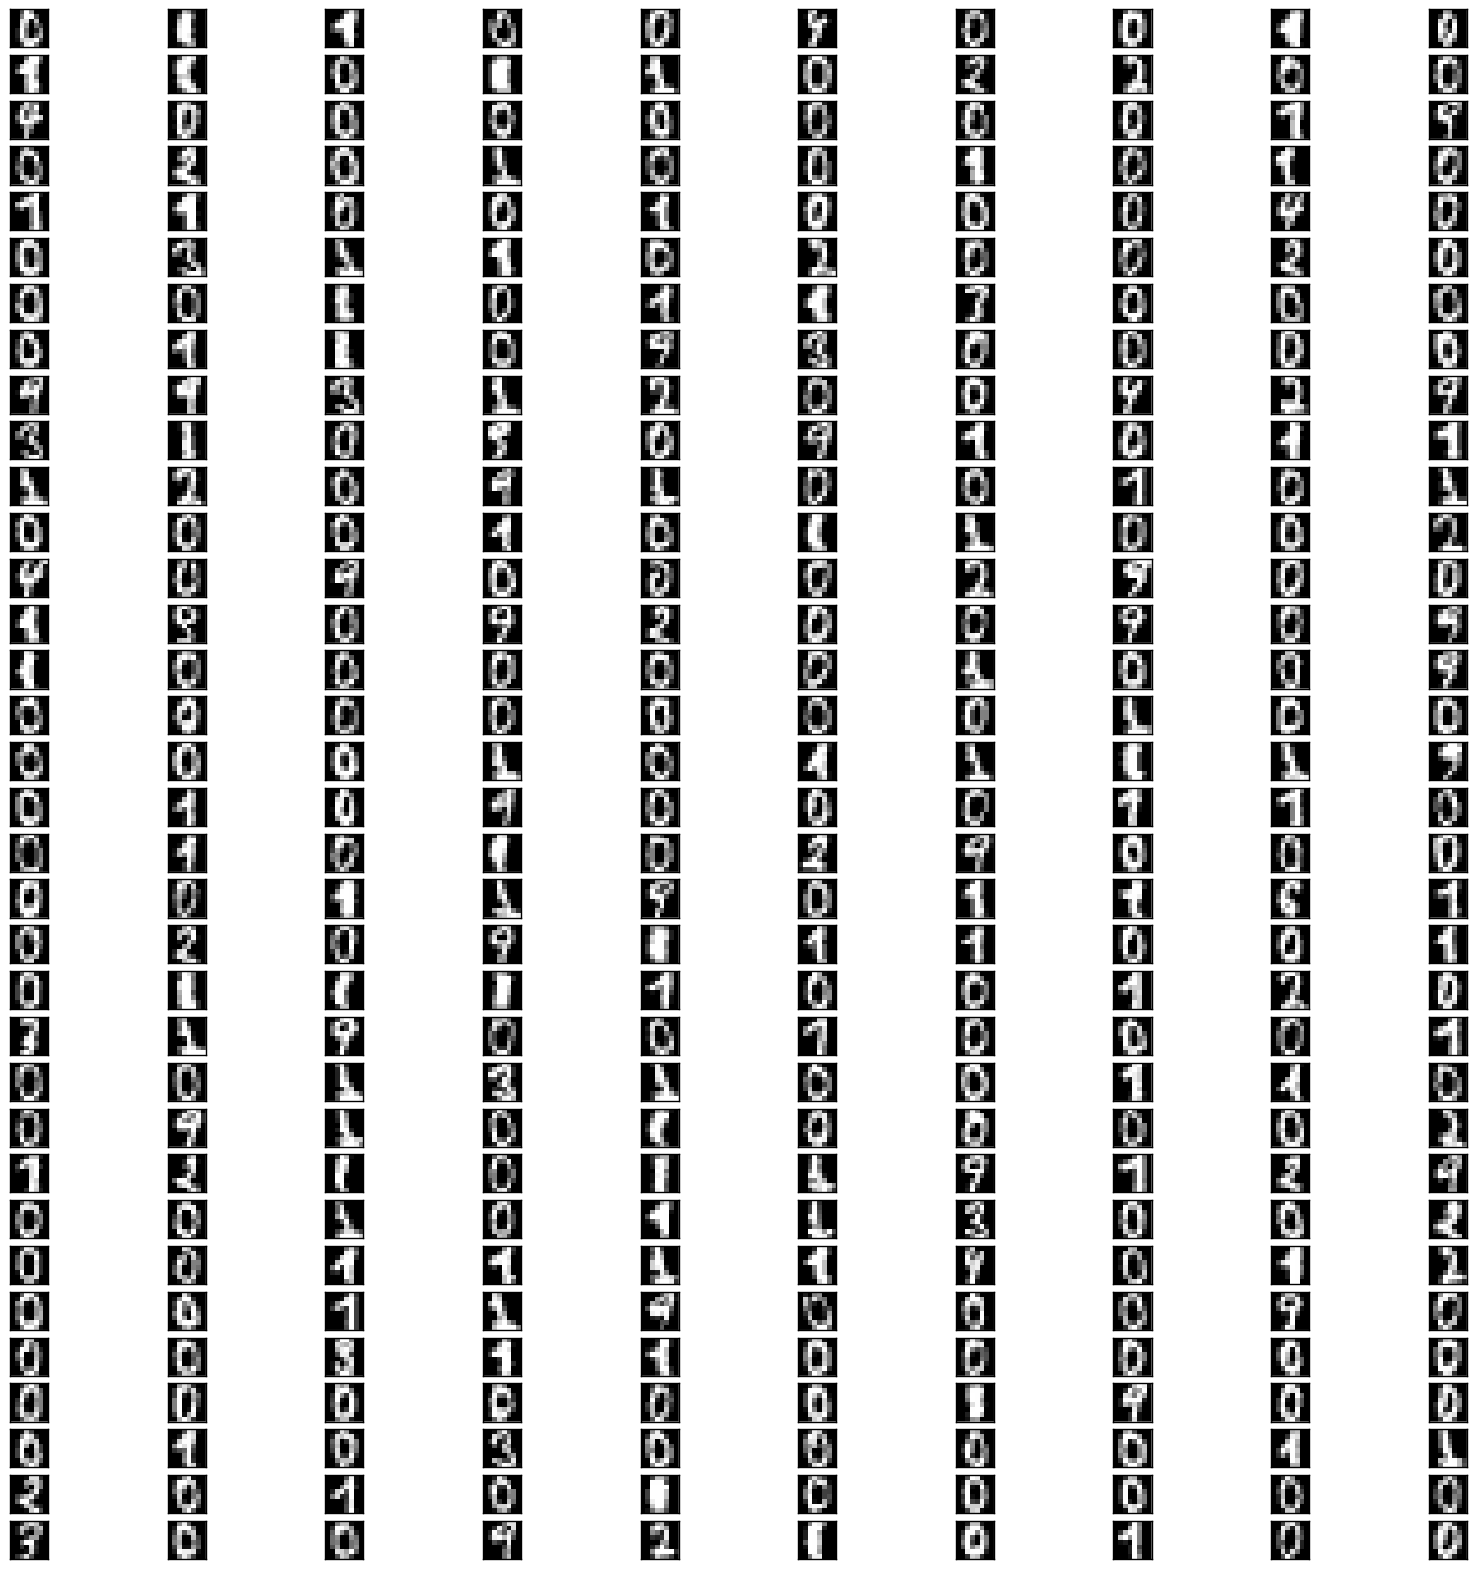

In [103]:
#имеем 340 таких картинок
plt.figure(figsize=(20,20))
for i in range(340):
    plt.subplot(34, 10, i + 1)
    plt.imshow(digits[0][perm][sets.pop()].reshape((8, 8)), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())


Произошло так потому что они кривые и похожи на некоторые другие цифры. Так же много ошибок на нулях, потому что они занимают много места на картинке и тоже похожи этим на все цифры подряд . 

## Разделение изображения на семантические компоненты

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных целях. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

Загрузите [изображения](https://www.dropbox.com/s/ybnvkemeus9wupe/images.zip?dl=0).

**(1 балл)** Для каждого изображения, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель вектором признаков $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

In [154]:
I_duck = imread('ducks.jpg', mode='RGB')
I_owl = imread('owl.jpg', mode='RGB')
N_REGIONS = 10
alpha = 2.5
duck_pixs = []
for i in range(I_duck.shape[0]):
    for j in range(I_duck.shape[1]):
        duck_pixs.append([alpha * i, alpha * j, I_duck[i,j][0], I_duck[i,j][1], I_duck[i,j][2]])

owl_pixs = []
for i in range(I_owl.shape[0]):
    for j in range(I_owl.shape[1]):
        owl_pixs.append([alpha * i, alpha * j, I_owl[i,j][0], I_owl[i,j][1], I_owl[i,j][2]])


In [155]:
kmeans_duck = KMeans(n_clusters=N_REGIONS, n_jobs=-1, init='random').fit(duck_pixs)
kmeans_owl = KMeans(n_clusters=N_REGIONS, n_jobs=-1, init='random').fit(owl_pixs)

**(1 балл)** Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

In [156]:
%%time
I_duck = color.rgb2gray(imread('ducks.jpg'))
I_owl = color.rgb2gray(imread('owl.jpg'))
I_duck = sp.misc.imresize(I_duck, 0.5)
I_owl = sp.misc.imresize(I_owl, 0.5)
graph_d = image.img_to_graph(I_duck)
graph_o = image.img_to_graph(I_owl)
beta = 4.1
eps = 0.001
graph_d.data = np.exp(-beta * graph_d.data / I_duck.std()) + eps
graph_o.data = np.exp(-beta * graph_o.data / I_owl.std()) + eps
sp_labels = []
for i, graph in [(I_duck, graph_d), (I_owl, graph_o)]:
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels='discretize',
                                 random_state=42)
    sp_labels.append(labels)

CPU times: user 9min 45s, sys: 16min 50s, total: 26min 35s
Wall time: 7min 8s


**(1 балл)** Визуализируйте результаты сегментации (аналогично рисунку выше) для обоих методов. [Пример кода для визуализации](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).

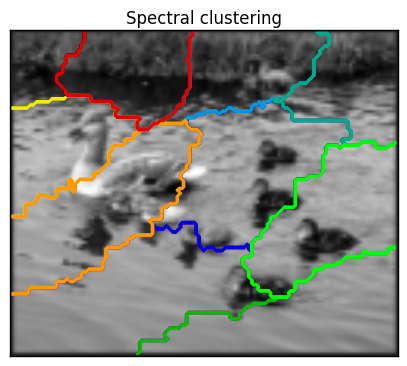

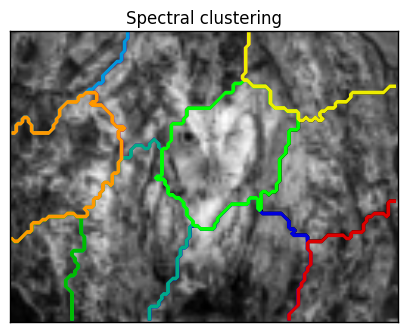

In [157]:
#Spectral
for i, labels in [(I_duck, sp_labels[0]), (I_owl, sp_labels[1])]:
    labels = labels.reshape(i.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(i,   cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering')

plt.show()

In [158]:
#KMEANS
I_duck = imread('ducks.jpg', mode='RGB')
I_owl = imread('owl.jpg', mode='RGB')
# kmeans_duck.labels_.shape

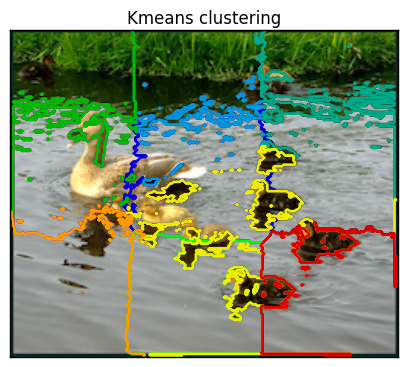

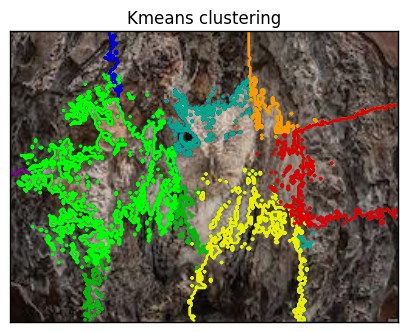

In [159]:
for km, im in [(kmeans_duck, I_duck), (kmeans_owl, I_owl)]:
    plt.figure(figsize=(5, 5))
    plt.imshow(im,   cmap=plt.cm.gray)
    labels = km.labels_.reshape((im.shape[0], im.shape[1]))
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1, colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Kmeans clustering')

**(1 балл)** Поэкспериментируйте с параметрами алгоритмов и параметром $\lambda$ в признаках. Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

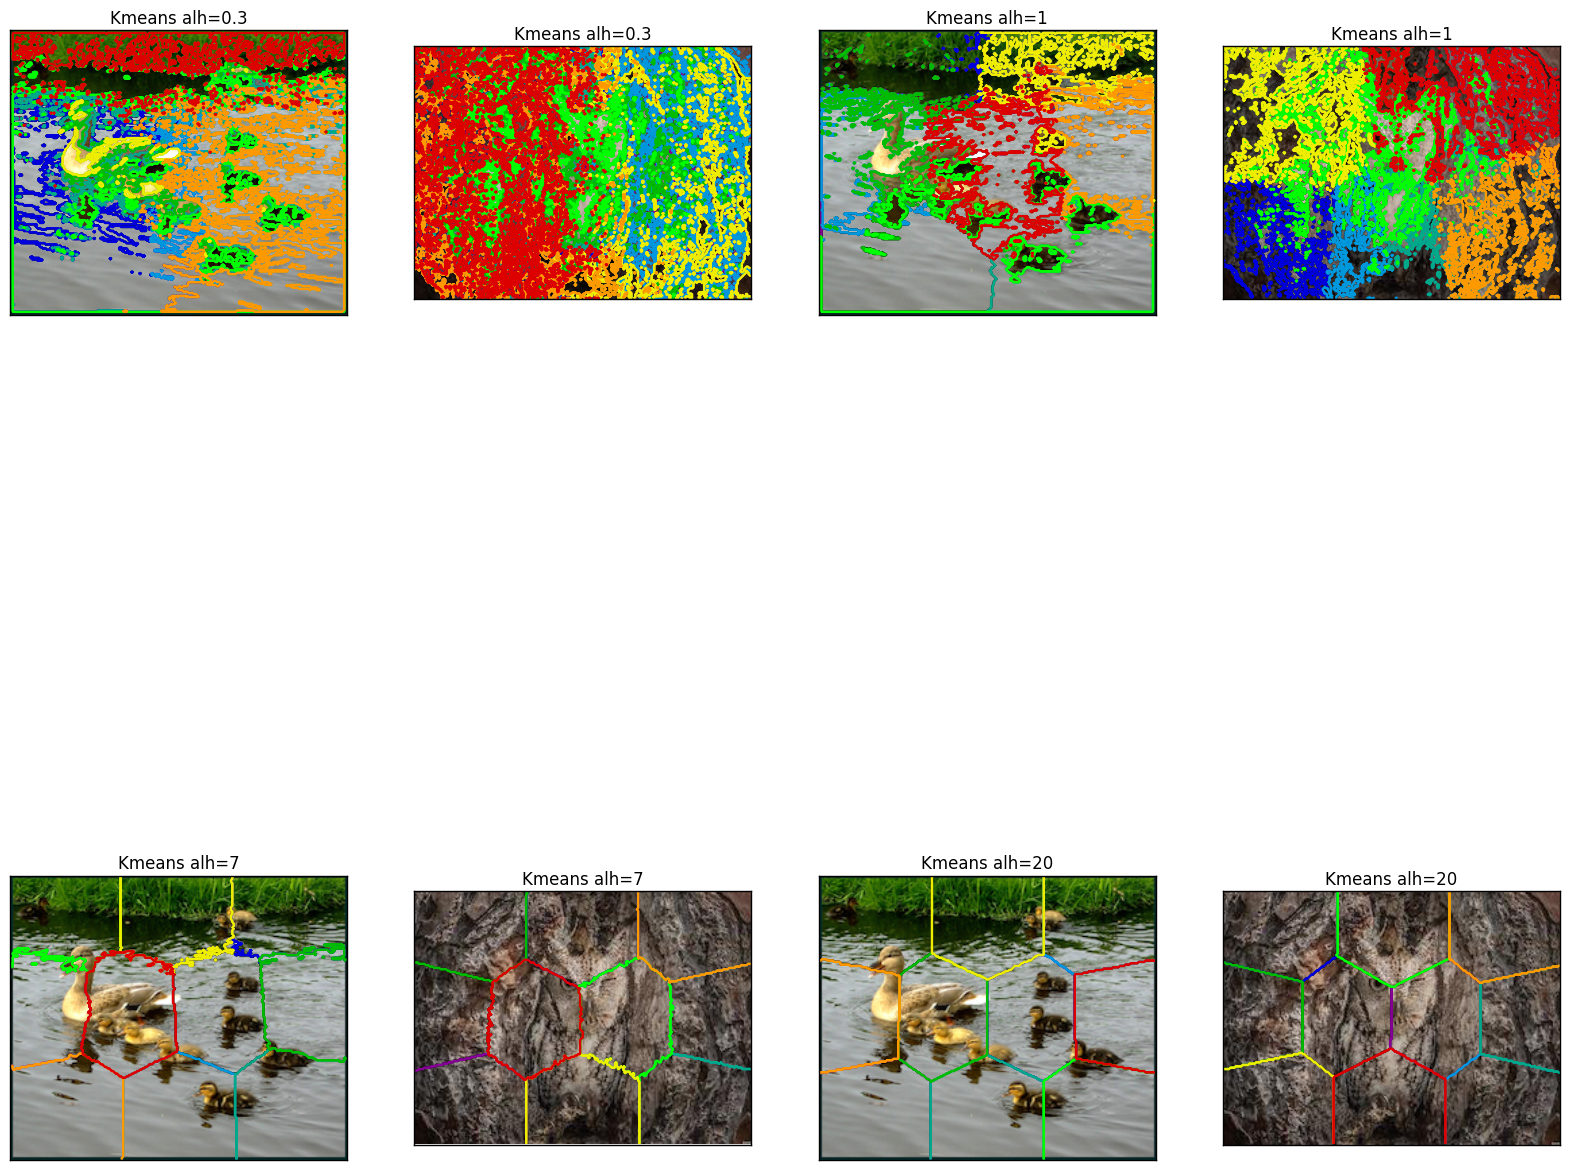

In [169]:
# KMEANS alpha

I_duck = imread('ducks.jpg', mode='RGB')
I_owl = imread('owl.jpg', mode='RGB')
N_REGIONS = 10
alpha = 2.5
sub = 0
plt.figure(figsize=(20, 20))
for alpha in [0.3, 1, 7, 20]:
    duck_pixs = []
    for i in range(I_duck.shape[0]):
        for j in range(I_duck.shape[1]):
            duck_pixs.append([alpha * i, alpha * j, I_duck[i,j][0], I_duck[i,j][1], I_duck[i,j][2]])

    owl_pixs = []
    for i in range(I_owl.shape[0]):
        for j in range(I_owl.shape[1]):
            owl_pixs.append([alpha * i, alpha * j, I_owl[i,j][0], I_owl[i,j][1], I_owl[i,j][2]])
            
    kmeans_duck = KMeans(n_clusters=N_REGIONS, n_jobs=-1, init='random').fit(duck_pixs)
    kmeans_owl = KMeans(n_clusters=N_REGIONS, n_jobs=-1, init='random').fit(owl_pixs)

    
    for km, im in [(kmeans_duck, I_duck), (kmeans_owl, I_owl)]:
        sub+=1
        plt.subplot(2, 4, sub)
#       
        plt.imshow(im,   cmap=plt.cm.gray)
        labels = km.labels_.reshape((im.shape[0], im.shape[1]))
        for l in range(N_REGIONS):
            plt.contour(labels == l, contours=1, colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
        plt.xticks(())
        plt.yticks(())
        plt.title('Kmeans alh=' + str(alpha))

На утках хорошо видно контуры при небольших альфа (0.3, 1, 2.5(картинка выше)). Сова хороша при 1 и 2.5. На больших альфа серменты обоих изображений одинаковые, контуры не выделены, так что с увеличением альфа качество снижается (тут сегменты начинают зависеть просто от координат за счет умножения на альфу x и y, яркость практически не влияет).

Теперь поглядим на K (alpha=2.5, т.е. лучшая на мой взгляд)

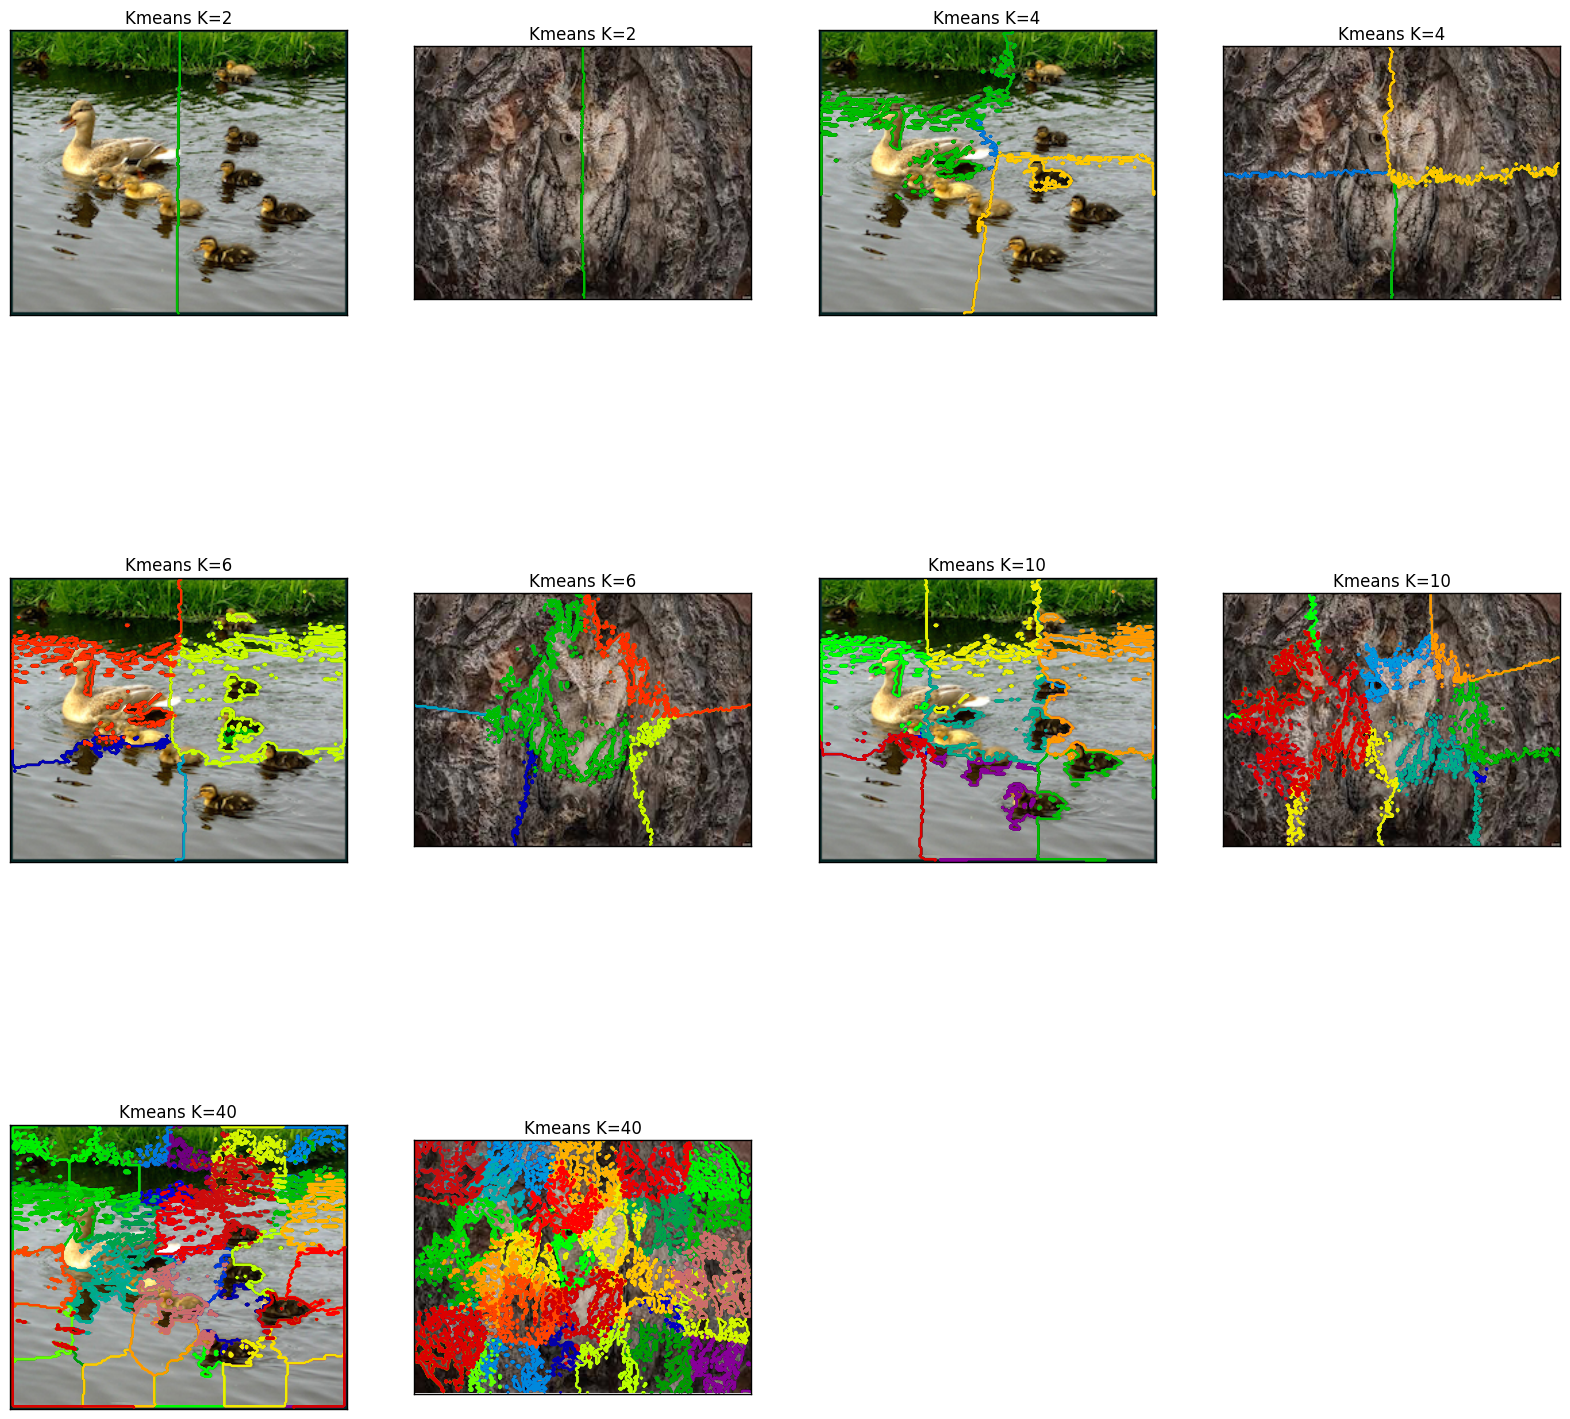

In [171]:
# KMEANS K

I_duck = imread('ducks.jpg', mode='RGB')
I_owl = imread('owl.jpg', mode='RGB')
N_REGIONS = 10
alpha = 2.5
sub = 0
plt.figure(figsize=(20, 20))
for N_REGIONS in [2, 4, 6, 10, 40]:
    duck_pixs = []
    for i in range(I_duck.shape[0]):
        for j in range(I_duck.shape[1]):
            duck_pixs.append([alpha * i, alpha * j, I_duck[i,j][0], I_duck[i,j][1], I_duck[i,j][2]])

    owl_pixs = []
    for i in range(I_owl.shape[0]):
        for j in range(I_owl.shape[1]):
            owl_pixs.append([alpha * i, alpha * j, I_owl[i,j][0], I_owl[i,j][1], I_owl[i,j][2]])
            
    kmeans_duck = KMeans(n_clusters=N_REGIONS, n_jobs=-1, init='random').fit(duck_pixs)
    kmeans_owl = KMeans(n_clusters=N_REGIONS, n_jobs=-1, init='random').fit(owl_pixs)

    
    for km, im in [(kmeans_duck, I_duck), (kmeans_owl, I_owl)]:
        sub+=1
        plt.subplot(3, 4, sub)
#       
        plt.imshow(im,   cmap=plt.cm.gray)
        labels = km.labels_.reshape((im.shape[0], im.shape[1]))
        for l in range(N_REGIONS):
            plt.contour(labels == l, contours=1, colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
        plt.xticks(())
        plt.yticks(())
        plt.title('Kmeans K=' + str(N_REGIONS))

Для данных изображений лучшими явзяются значения k в интервале от 5 до 10-12 (тут контруры уток и совы хорошо выделяются при K=6, 10). 40 слишком много, выделяются незначительные сегменты, размывающие контуры. 2, 4 - слишком мало - не достяточно для выделения границ основных цветов(контуров объектов) на данных картинках.

Спектральный подход:

CPU times: user 5min 40s, sys: 9min 25s, total: 15min 6s
Wall time: 3min 52s


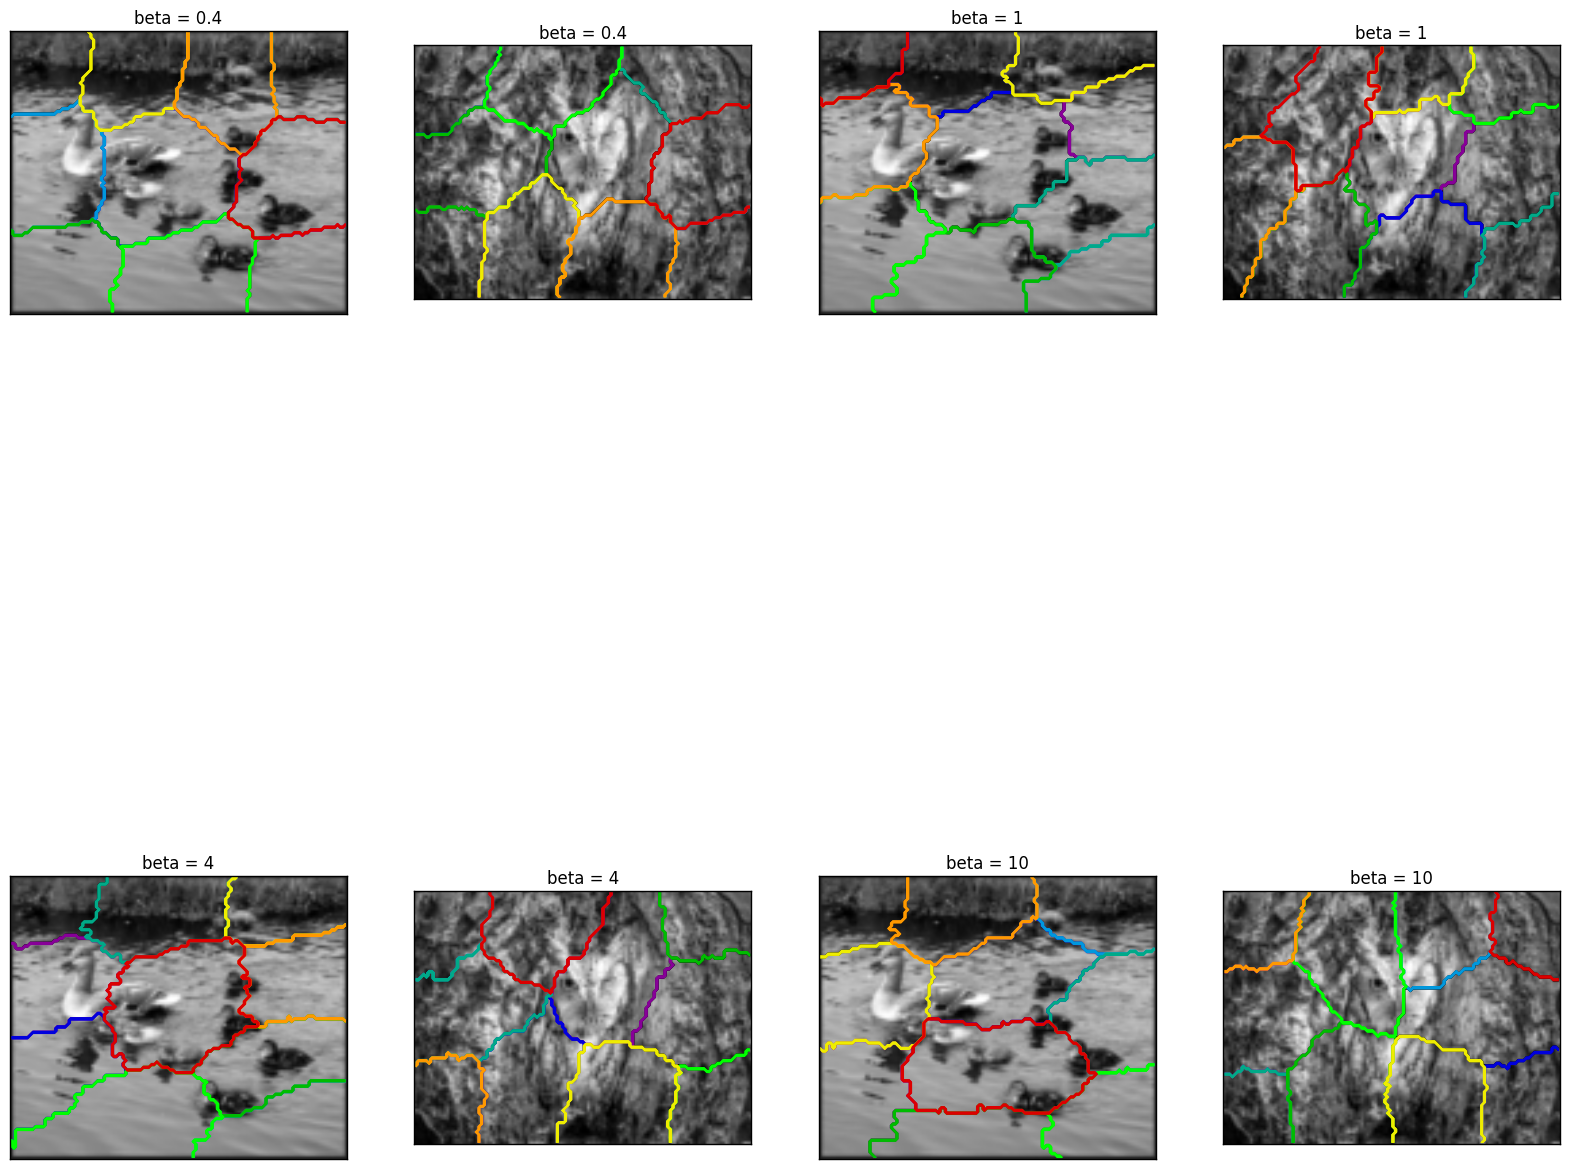

In [175]:
%%time
I_duck = color.rgb2gray(imread('ducks.jpg'))
I_owl = color.rgb2gray(imread('owl.jpg'))
I_duck = sp.misc.imresize(I_duck, 0.5)
I_owl = sp.misc.imresize(I_owl, 0.5)
graph_d = image.img_to_graph(I_duck)
graph_o = image.img_to_graph(I_owl)
N_REGIONS = 10
beta = 4.1
eps = 0.01
sub=0
plt.figure(figsize=(20, 20))
for beta in [0.4, 1, 4, 10]:
    graph_d = image.img_to_graph(I_duck)
    graph_o = image.img_to_graph(I_owl)
    graph_d.data = np.exp(-beta * graph_d.data / I_duck.std()) + eps
    graph_o.data = np.exp(-beta * graph_o.data / I_owl.std()) + eps
#     sp_labels = []
    for i, graph in [(I_duck, graph_d), (I_owl, graph_o)]:
        labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                     assign_labels='discretize',
                                     random_state=42)
#         sp_labels.append(labels)
#     for i, labels in [(I_duck, sp_labels[0]), (I_owl, sp_labels[1])]:
        labels = labels.reshape(i.shape)
#         plt.figure(figsize=(5, 5))
        sub+=1
        plt.subplot(2, 4, sub)
        plt.imshow(i,   cmap=plt.cm.gray)
        for l in range(N_REGIONS):
            plt.contour(labels == l, contours=1,
                        colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
        plt.xticks(())
        plt.yticks(())
        plt.title('beta = ' + str(beta))

# plt.show()

Спектральный кластеринг с discretize не виделяет контуры объектов (часто граница проходит прямо по объектам). По К не интересно смотреть (будет просто сегментов побольше и никакого качественного изменения), попробуем по эпсилон, и заодно поменяем метод на kmeans, можно будет поглядеть на разницу с оригинальным:

DONE
DONE
DONE
DONE
CPU times: user 7min 10s, sys: 12min 35s, total: 19min 46s
Wall time: 5min 10s


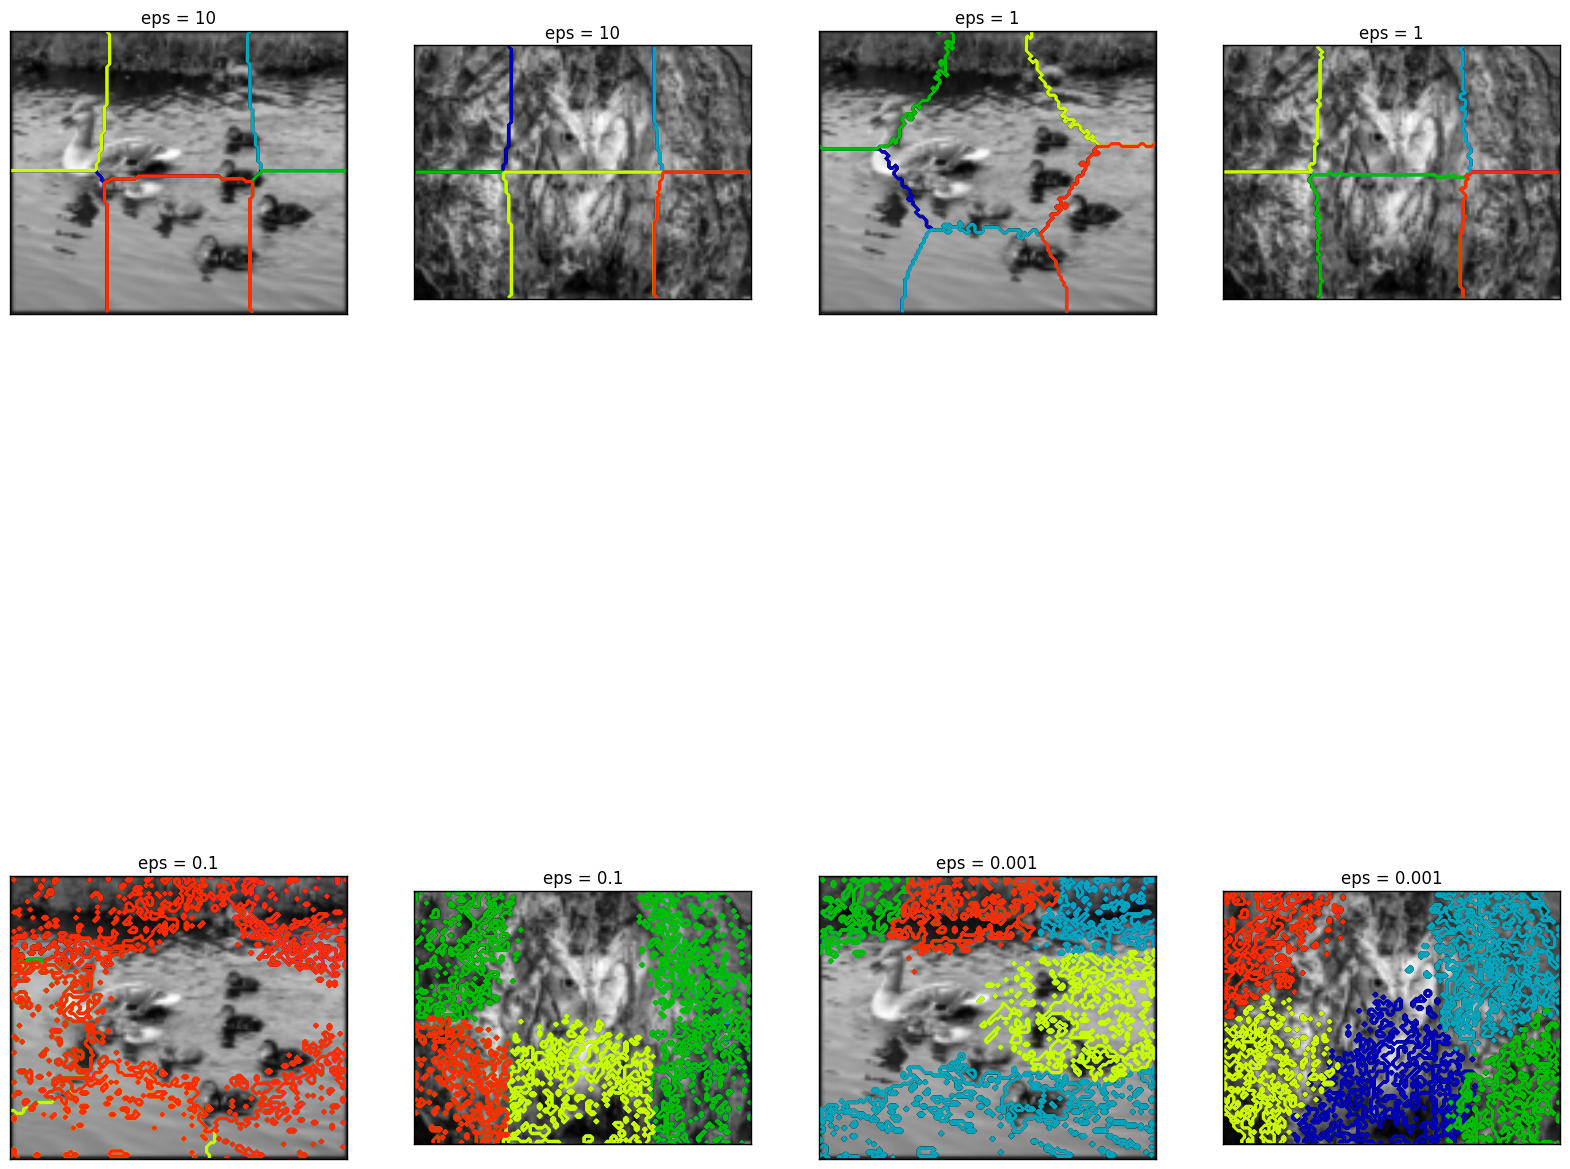

In [177]:
%%time
I_duck = color.rgb2gray(imread('ducks.jpg'))
I_owl = color.rgb2gray(imread('owl.jpg'))
I_duck = sp.misc.imresize(I_duck, 0.5)
I_owl = sp.misc.imresize(I_owl, 0.5)

N_REGIONS = 6
beta = 4.2
eps = 0.01
sub=0
plt.figure(figsize=(20, 20))
for eps in [10, 1, 0.1, 0.001]:
    graph_d = image.img_to_graph(I_duck)
    graph_o = image.img_to_graph(I_owl)
    graph_d.data = np.exp(-beta * graph_d.data / I_duck.std()) + eps
    graph_o.data = np.exp(-beta * graph_o.data / I_owl.std()) + eps
#     sp_labels = []
    for i, graph in [(I_duck, graph_d), (I_owl, graph_o)]:
        labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                     assign_labels='kmeans',
                                     random_state=42)
#         sp_labels.append(labels)
#     for i, labels in [(I_duck, sp_labels[0]), (I_owl, sp_labels[1])]:
        labels = labels.reshape(i.shape)
#         plt.figure(figsize=(5, 5))
        sub+=1
        plt.subplot(2, 4, sub)
        plt.imshow(i,   cmap=plt.cm.gray)
        for l in range(N_REGIONS):
            plt.contour(labels == l, contours=1,
                        colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
        plt.xticks(())
        plt.yticks(())
        plt.title('eps = ' + str(eps))
    print("DONE")

# plt.show()

Качество растет с уменьшением eps, но все равно сегментация Kmeans лучше. В данном примере даже на 0.001 контуры объектов выявлены плохо (хотя при assign_labels='discretize' вообще контуров нет, а тут хоть что-то). В основном изображдение разделилось по оттенкам цвета, поэтому контуров совы не видно совсем (картинка менее контрастная чем утки). При K=6 все изображение покрыть не удалось, нужно больше сегментом. Результаты KMeans по итогам испытаний ммне кажутся более понятными чем результаты sspectral_clustering.

Измерять качество сегментации в этом пункте не нужно, в результате ожидаются только картинки и выводы.

### Рекомендации к выполнению
Для работы с изображениями удобно использовать библиотеку [Scikit-Image](http://scikit-image.org). 
Установите [PIL](http://www.pythonware.com/products/pil/) для возможности чтения формата JPG.

Пример чтения изображения в матрицу:

    from skimage.io import imread
    I = imread('http://www.birdsgallery.net/gallery/parrots/parrots_4.jpg')

    figure(figsize=(15, 5))
        for i in xrange(3):
        subplot(1, 3, i)
        imshow(I[:,:,i])

## Word2vec

**(3 балла)**
1. [Скачайте данные](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)
2. [Установите необходимые библиотеки](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/setting-up-your-system)
3. Внимательно изучите тьториалы, доступные в рамках контеста [Part 1](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words) – [Part 4](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-4-comparing-deep-and-non-deep-learning-methods). Эти статьи очень полезны для понимания принципов анализа текстовых данных в питоне.
4. Согласно тьюториалам подготовить данные и обучить модель word2vec. Полезно засечь время обучения модели.
5. Протестировать модель на датасете, подготовленном Google, с задачами вида: *London → England*, значит, *Berlin → Germany*. Пример вызова нужной функции и описание датасета есть [тьюториале по word2vec](https://rare-technologies.com/word2vec-tutorial/). Сам датасет можно скачать по [ссылке](https://www.dropbox.com/s/prb8n5b5na5qo07/questions-words.txt?dl=0).С чем может быть связано большое число неверных ответов?
6. Привести по 5-10 примеров для задачи поиска лишнего слова *(model.doesnt_match)* и для задачи поиска семантически близких слов *(model.most_similar)*. Проинтерпретировать полученные результаты. Все ли примеры соответствуют здравому смыслу? По каким принципам группируются близкие слова в выбранных вами примерах?

Ну что ж, тьюториал так тьюториал...
код отсюда: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors

In [7]:
import pandas as pd

train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

print ("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size,  test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [8]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return(words)

In [9]:
import nltk.data
nltk.download()   

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    return sentences

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [12]:
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)


Parsing sentences from training set


/home/wamkelekile/Storage/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/wamkelekile/Storage/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:198: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
/home/wamkelekile/Storage/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:207: UserWarning: "b'http://www.happierabroa

Parsing sentences from unlabeled set


/home/wamkelekile/Storage/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:207: UserWarning: "b'http://www.archive.org/details/LovefromaStranger"'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/home/wamkelekile/Storage/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:207: UserWarning: "b'http://www.loosechangeguide.com/LooseChangeGuide.html"'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed tha

In [15]:
%%time
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)
model.init_sims(replace=True)
model_name = "300features_40minwords_10context"
model.save(model_name)

/home/wamkelekile/Storage/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
2016-12-17 20:18:31,679 : INFO : 'pattern' package not found; tag filters are not available for English
2016-12-17 20:18:32,317 : INFO : collecting all words and their counts
2016-12-17 20:18:32,317 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-17 20:18:32,410 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2016-12-17 20:18:32,498 : INFO : PROGRESS: at sentence #20000, processed 451887 words, keeping 24948 word types


Training model...


2016-12-17 20:18:32,590 : INFO : PROGRESS: at sentence #30000, processed 671310 words, keeping 30034 word types
2016-12-17 20:18:32,679 : INFO : PROGRESS: at sentence #40000, processed 897810 words, keeping 34348 word types
2016-12-17 20:18:32,762 : INFO : PROGRESS: at sentence #50000, processed 1116958 words, keeping 37761 word types
2016-12-17 20:18:32,840 : INFO : PROGRESS: at sentence #60000, processed 1338399 words, keeping 40723 word types
2016-12-17 20:18:32,910 : INFO : PROGRESS: at sentence #70000, processed 1561573 words, keeping 43333 word types
2016-12-17 20:18:32,985 : INFO : PROGRESS: at sentence #80000, processed 1780880 words, keeping 45714 word types
2016-12-17 20:18:33,059 : INFO : PROGRESS: at sentence #90000, processed 2004989 words, keeping 48135 word types
2016-12-17 20:18:33,131 : INFO : PROGRESS: at sentence #100000, processed 2226945 words, keeping 50207 word types
2016-12-17 20:18:33,212 : INFO : PROGRESS: at sentence #110000, processed 2446559 words, keeping 

CPU times: user 7min 9s, sys: 1.98 s, total: 7min 11s
Wall time: 2min 11s


Модель обучилась, поглядим долю правильных ответов на гугл датасете:

In [42]:
model.accuracy('questions-words.txt')

2016-12-17 20:54:28,307 : INFO : capital-common-countries: 24.5% (27/110)
2016-12-17 20:54:28,548 : INFO : capital-world: 17.6% (12/68)
2016-12-17 20:54:28,681 : INFO : currency: 0.0% (0/40)
2016-12-17 20:54:29,281 : INFO : city-in-state: 0.5% (1/188)
2016-12-17 20:54:30,452 : INFO : family: 68.2% (259/380)
2016-12-17 20:54:33,091 : INFO : gram1-adjective-to-adverb: 7.2% (63/870)
2016-12-17 20:54:34,499 : INFO : gram2-opposite: 9.5% (44/462)
2016-12-17 20:54:37,701 : INFO : gram3-comparative: 55.3% (584/1056)
2016-12-17 20:54:39,374 : INFO : gram4-superlative: 38.5% (195/506)
2016-12-17 20:54:41,476 : INFO : gram5-present-participle: 39.2% (255/650)
2016-12-17 20:54:43,556 : INFO : gram6-nationality-adjective: 18.3% (125/684)
2016-12-17 20:54:46,743 : INFO : gram7-past-tense: 40.0% (422/1056)
2016-12-17 20:54:49,202 : INFO : gram8-plural: 36.1% (293/812)
2016-12-17 20:54:50,881 : INFO : gram9-plural-verbs: 58.9% (325/552)
2016-12-17 20:54:50,882 : INFO : total: 35.0% (2605/7434)


[{'correct': [('BANGKOK', 'THAILAND', 'BERLIN', 'GERMANY'),
   ('BANGKOK', 'THAILAND', 'LONDON', 'ENGLAND'),
   ('BANGKOK', 'THAILAND', 'PARIS', 'FRANCE'),
   ('BANGKOK', 'THAILAND', 'TOKYO', 'JAPAN'),
   ('BEIJING', 'CHINA', 'BERLIN', 'GERMANY'),
   ('BEIJING', 'CHINA', 'LONDON', 'ENGLAND'),
   ('BEIJING', 'CHINA', 'PARIS', 'FRANCE'),
   ('BEIJING', 'CHINA', 'TOKYO', 'JAPAN'),
   ('BERLIN', 'GERMANY', 'LONDON', 'ENGLAND'),
   ('BERLIN', 'GERMANY', 'TOKYO', 'JAPAN'),
   ('CAIRO', 'EGYPT', 'TOKYO', 'JAPAN'),
   ('CAIRO', 'EGYPT', 'BEIJING', 'CHINA'),
   ('HAVANA', 'CUBA', 'PARIS', 'FRANCE'),
   ('LONDON', 'ENGLAND', 'PARIS', 'FRANCE'),
   ('LONDON', 'ENGLAND', 'TOKYO', 'JAPAN'),
   ('LONDON', 'ENGLAND', 'BEIJING', 'CHINA'),
   ('LONDON', 'ENGLAND', 'BERLIN', 'GERMANY'),
   ('MADRID', 'SPAIN', 'PARIS', 'FRANCE'),
   ('MADRID', 'SPAIN', 'TOKYO', 'JAPAN'),
   ('MOSCOW', 'RUSSIA', 'TOKYO', 'JAPAN'),
   ('MOSCOW', 'RUSSIA', 'BANGKOK', 'THAILAND'),
   ('MOSCOW', 'RUSSIA', 'LONDON', 'ENGLAND')

2016-12-17 20:54:28,307 : INFO : capital-common-countries: 24.5% (27/110)

2016-12-17 20:54:28,548 : INFO : capital-world: 17.6% (12/68)

2016-12-17 20:54:28,681 : INFO : currency: 0.0% (0/40)

2016-12-17 20:54:29,281 : INFO : city-in-state: 0.5% (1/188)

2016-12-17 20:54:30,452 : INFO : family: 68.2% (259/380)

2016-12-17 20:54:33,091 : INFO : gram1-adjective-to-adverb: 7.2% (63/870)

2016-12-17 20:54:34,499 : INFO : gram2-opposite: 9.5% (44/462)

2016-12-17 20:54:37,701 : INFO : gram3-comparative: 55.3% (584/1056)

2016-12-17 20:54:39,374 : INFO : gram4-superlative: 38.5% (195/506)

2016-12-17 20:54:41,476 : INFO : gram5-present-participle: 39.2% (255/650)

2016-12-17 20:54:43,556 : INFO : gram6-nationality-adjective: 18.3% (125/684)

2016-12-17 20:54:46,743 : INFO : gram7-past-tense: 40.0% (422/1056)

2016-12-17 20:54:49,202 : INFO : gram8-plural: 36.1% (293/812)

2016-12-17 20:54:50,881 : INFO : gram9-plural-verbs: 58.9% (325/552)

2016-12-17 20:54:50,882 : INFO : total: 35.0% (2605/7434)

Вообщем видно большое число неверных ответов во многих категориях. Связано это, в основном с тем, что мы обучили модель на маленьком количестве данных. Можно улучшить качество, меняя параметры модели: Downsampling of frequent words, Architecture, Word vector dimensionality, Context / window size, Minimum word count, etc. Прирост доли правильных ответов будет, однако, сильного изменения можно добиться только обучением на большем объеме данных. 

Так же можно заметить, что accuracy выше на вопросах, соответствующих специфике данных (по сути, обзорам фильмов). Вопросы про сравнительную степень, про превосходную, прошедшее время (это же все про описания=обзоры), про семью (это часть сюжета в ~90% случаев). Так же качество неплохое на встречающихся повсеместно связях (множественное число, причастиях). Плохое качество на связях встречающихся в обзорах редко либо просто сложных(напр. city-in-state (надо было обучаться на учебниках истории разных стран или чем нибудь таком), opposite). 
35% это неплохо для такого количества данных и времени обучения.

Привести по 5-10 примеров model.doesnt_match и model.most_similar:

In [50]:
most_similar_to = ["man", "door", "nut", "actor", "work", "death", "see", "love"]
for item in most_similar_to:
    print(item, "is similar to:", ','.join([i[0] for i in model.most_similar(item)]))


man is similar to: woman,lad,lady,monk,farmer,soldier,guy,businessman,millionaire,men
door is similar to: doors,desk,glass,ceiling,window,sits,doorway,floor,wheel,upstairs
nut is similar to: policeman,mobster,salesman,bastard,thug,homicidal,biker,billionaire,operative,bald
actor is similar to: actress,performer,comedian,role,actors,performance,artist,thespian,villain,impersonation
work is similar to: craft,angles,works,mugging,efforts,filmmaking,artistry,storytelling,skill,job
death is similar to: demise,suicide,witnessing,fate,confession,cancer,destruction,sins,murder,accident
see is similar to: watch,hear,imagine,catch,find,know,tell,learn,forgive,relate
love is similar to: loves,hate,adore,friendship,asleep,despise,loved,romance,passion,romantic


Большинсвто здесь соответствует здравому смыслу. Похожие слова формируются по принципу, сильно связанному со спецификой датасета. Например, для слова nut нашлись слова по смыслу схожие с его редкоупотребимыми значениями, однако, более соответствующие тематике фильмов (~дурачек, псих, бандит и тд.). Для остального вроде не интересно. т.е. обычно, вроде man это мужские профессии + слова которые обычно в паре идут, вроде "мужчина и женщина" (в фильмах всегда так, есть линия отношений в сюжете). door это как интерьер, стулья, окна и тд. Все в таком духе. Много точных синонимов для actor, love, see (обычная тема, много примеров в данных).    

In [51]:
find_outlier = ["cat dog bird bycicle", "computer smartphone tv street", "music art history poem",
                "deadth hate love friendship", "water gel lava rubber", "pen pencil marker eraser",
               "air sun grass inside"]
for item in find_outlier:
    print(item, "::::", model.doesnt_match(item.split()))

cat dog bird bycicle :::: bird
computer smartphone tv street :::: street
music art history poem :::: music
deadth hate love friendship :::: friendship
water gel lava rubber :::: gel
pen pencil marker eraser :::: pencil
air sun grass inside :::: inside


Оч интересно. Вообщем, я задумал другие ответы в 5 из 7 случаев. Может, я придумал слишком сложные загадки (например music art history poem :::: music).  water gel lava rubber :::: gel - здесь поидее должна быть резина потому что она твердая, но вообще, гель вприницпе тоже логично, потому что твердый гель это странно, а все остальное может затвердеть. Остальные ошибки не объяснить. Вообще, все что происходит в графах вычислений, обычно, не поддается объяснению. pen pencil marker eraser :::: pencil человеку тут очевидно - ластик, а сети нет. Вообщем, по результатам этого задания логика и точность чуть хуже. Возможно, стоило придумать наборы по темам более сообразным с фильмами. 

Здесь ответы не очень соответствуют здравому смыслу.